# Convergencia Tipo X

In [1]:
import numpy as np
import pandas as pd

import sys, os

from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
import sys, os; sys.path.append(os.path.dirname(os.getcwd()))
from pyfrechet.metric_spaces import MetricData, LogCholesky, spd_to_log_chol, log_chol_to_spd
from pyfrechet.regression.bagged_regressor import BaggedRegressor
from pyfrechet.regression.trees import Tree
from sklearn.model_selection import train_test_split
from pyfrechet.metric_spaces import MetricData, LogEuclidean, CustomAffineInvariant, CustomLogEuclidean, AffineInvariant, LogCholesky, log_chol_to_spd, spd_to_log_chol

from typing import Union
import random

from pyfrechet.metric_spaces import MetricData, Wasserstein1D
from pyfrechet.metric_spaces import wasserstein_1d as ws
from scipy import stats 

INFO: Using numpy backend


## Functions

In [2]:
GRID = np.linspace(0.01, 0.99, 100)
STD_NORMAL_Q = stats.norm.ppf(GRID)


def sample_linear_transport(x, sig=1, gam=0.5):
    gam = np.random.gamma(0.5, 0.5)
    sig = np.random.exponential(0.5)
    Q0 = gam - np.log(1 + x) + (sig + x**2) * STD_NORMAL_Q
    return Q0 
    
def gen_data(N, x0 = 0):
    # We know the values of Q in a grid, and we interpolate to estimate the values of Q in the new grid
    x = np.repeat(x0, N)
    y = np.array([ sample_linear_transport(x[i]) for i in range(N)])
    
    return {'x': x, 'y': y}

In [3]:
# Obtain coverage results dataframe from the results files
def coverage_results() -> pd.DataFrame:
    coverage_df=pd.DataFrame(columns=['sample_index', 'y_train_data', 'train_predictions', 'OOB_quantile', 'OOB_errors', 'forest'])
    for file in os.listdir(os.path.join(os.getcwd(), 'wass_results')):
        if file.endswith('.npy'):
            infile=open(os.path.join(os.getcwd(), 'wass_results/'+file), 'rb')
            result=np.load(infile, allow_pickle=True).item()
            infile.close()
            coverage_df=pd.concat([coverage_df, 
                                    pd.DataFrame({  'sample_index': int(file.split('_')[1][4:]),
                                                    'y_train_data': [result['y_train_data']],
                                                    'train_predictions': [result['train_predictions']],
                                                    'forest': [result['forest']],
                                                }, index=pd.RangeIndex(0,1))],
                                    ignore_index=True)
        
    coverage_df['sample_index']=coverage_df['sample_index'].astype('category')
    return coverage_df

coverage_df=coverage_results()

In [ ]:
coverage_df['OOB_errors'] = coverage_df.apply(lambda row: row['forest'].oob_errors(), axis=1)
sign_level = [0.01, 0.05, 0.1]
coverage_df['OOB_quantile'] = coverage_df.apply(lambda row: np.percentile(row['OOB_errors'], (1 - sign_level) * 100), axis=1)

In [4]:
n_estimations = 1

MC = 1000

zeros_init = np.zeros(shape = (n_estimations, 3))
cov = np.zeros(shape = (n_estimations, 3))

# Obtain 25 estimations of Type I coverage error for each distance and N, to calculate the mean of the estimations and the sample variance
M = Wasserstein1D()

for estimation in range(n_estimations):
    yesno = np.zeros(3)
    # Randomly select rows from the dataframe

    new_ts, new_ys = gen_data(MC, x0 = 0).values()

    lns = coverage_df.sample(n=MC, replace = True)

    i = 0
    for _, ln in lns.iterrows():
        # Generate one random point to test if it belongs to the prediction ball
        new_t = new_ts[i]
        #new_t = np.random.uniform(size = 1)
        #Predict the new observation
        new_pred = ln['forest'].predict(new_t.reshape(-1,1))
        new_y = new_ys[i]
        #new_y = sim_regression_matrices(Sigmas = (Sigma_1, Sigma_2, Sigma_3), 
        #            t = new_t,  
        #            df = df)['y'][0]
        # Store the selected values
        yesno = np.vstack((yesno, M.d(new_pred, new_y) <= ln['OOB_quantile']))
        i += 1
    cov[estimation, :] = yesno[1:,:].sum(axis=0) / MC
    
cov

array([[0.989, 0.952, 0.902]])

In [5]:
def sample_linear_transport(x, sig=1, gam=0.5):
    gam = np.random.gamma(0.5, 0.5)
    sig = np.random.exponential(0.5)
    Q0 = gam - np.log(1 + x) + (sig + x**2) * STD_NORMAL_Q
    return Q0 
    
def gen_data(N, x0 = 0):
    # We know the values of Q in a grid, and we interpolate to estimate the values of Q in the new grid
    x = np.repeat(x0, N)
    y = np.array([ sample_linear_transport(x[i]) for i in range(N)])
    
    return {'x': x, 'y': y}

def sample_linear_transport2(x, sig=1, gam=0.5):
    gam = np.random.uniform(0,4)
    sig = np.random.uniform(0,4)
    Q0 = gam - np.log(1 + x) + (sig + x**2) * STD_NORMAL_Q
    return Q0 
    
def gen_data2(N, x0 = 0):
    # We know the values of Q in a grid, and we interpolate to estimate the values of Q in the new grid
    x = np.repeat(x0, N)
    y = np.array([ sample_linear_transport2(x[i]) for i in range(N)])
    
    return {'x': x, 'y': y}

def sample_linear_transport3(x, sig=1, gam=0.5):
    gam = np.random.uniform(0,4)
    sig = np.random.uniform(0,4)
    Q0 = - gam - np.log(1 + x) + (sig + x**2) * STD_NORMAL_Q
    return Q0 
    
def gen_data3(N, x0 = 0):
    # We know the values of Q in a grid, and we interpolate to estimate the values of Q in the new grid
    x = np.repeat(x0, N)
    y = np.array([ sample_linear_transport3(x[i]) for i in range(N)])
    
    return {'x': x, 'y': y}

In [6]:
gen_data(1)['y'][0]

array([0.10738638, 0.11205099, 0.11501812, 0.1172522 , 0.11907022,
       0.12061797, 0.12197519, 0.12319048, 0.12429574, 0.12531311,
       0.12625861, 0.12714423, 0.12797918, 0.1287707 , 0.12952461,
       0.13024563, 0.13093768, 0.13160403, 0.13224744, 0.13287029,
       0.13347461, 0.13406217, 0.13463453, 0.13519305, 0.13573895,
       0.13627331, 0.13679709, 0.13731117, 0.13781636, 0.13831336,
       0.13880285, 0.13928542, 0.13976164, 0.14023203, 0.14069707,
       0.14115721, 0.14161288, 0.14206448, 0.14251237, 0.14295692,
       0.14339847, 0.14383735, 0.14427386, 0.14470832, 0.14514101,
       0.14557222, 0.14600222, 0.1464313 , 0.14685971, 0.14728773,
       0.14771561, 0.14814363, 0.14857204, 0.14900112, 0.14943112,
       0.14986233, 0.15029502, 0.15072948, 0.15116599, 0.15160487,
       0.15204642, 0.15249097, 0.15293887, 0.15339046, 0.15384613,
       0.15430627, 0.15477131, 0.1552417 , 0.15571792, 0.15620049,
       0.15668998, 0.15718698, 0.15769217, 0.15820625, 0.15873

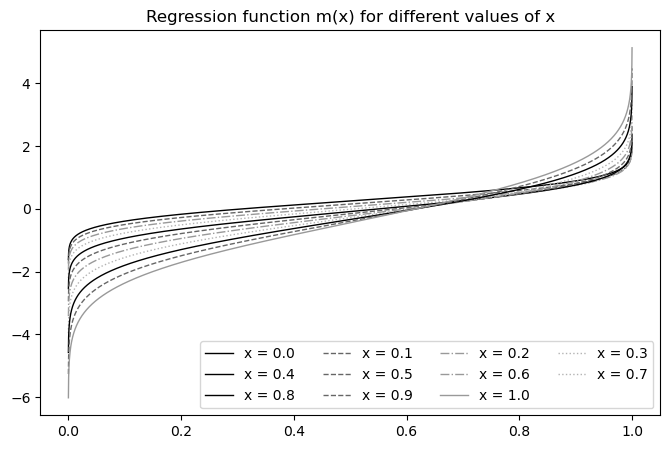

In [13]:
np.random.seed(1000)
reorder = lambda l, nc: sum((l[i::nc] for i in range(nc)), [])

new_grid = np.linspace(0, 1, 10000)
new_quantile = stats.norm.ppf(new_grid)
fig, ax = plt.subplots(1, 1, figsize=(8, 5), facecolor="white")

line_styles = ['-', '--', '-.', ':', '-', '--', '-.', ':', '-', '--']

for i, x in enumerate(np.linspace(0, 1, 11, endpoint=True)):
    Q1 = 1/4 - np.log(1 + x) + (1/2 + x**2) * new_quantile
    ax.plot(new_grid, Q1, linestyle=line_styles[i % len(line_styles)], linewidth=1, label=np.round(x, 2))

    h, l = ax.get_legend_handles_labels()
    ax.legend(reorder(h, 4), [f'x = {label}' for label in reorder(l, 4)], ncol=4, loc=4)

plt.style.use('grayscale')
plt.title('Regression function m(x) for different values of x')
plt.savefig('m(x).eps', format='eps')